# Measuring the floating point performance of your machine

Matrix-Matrix multiplication is often used to benchmark machines because the mathematics is such that it is one of the few operations where one can obtain close to theoretical peak performance in pratice.

The number of floating point operations(Flops) in a Matrix-Matrix multiplication of two $N$ x $N$ matrices is given by $2N^3-N^2$ (See http://www2.hawaii.edu/~norbert/CompPhys/compphysicsch10.html for details of how this was determined).

For this benchmark, we construct two random $N$ x $N$ matrices and time how long it takes to multiply them together, $t$. We then compute the number of Gigaflops/s exhibited by that operation via $\frac{2N^3-N^2}{t*10^9}$. We do this several times for any given $N$ and record the average and the best (peak) results obtained.  $N$ is then varied from 250 to 10,000 in steps of 250 to see how performance varies with matrix size.  Usually, the highest performance is obtained by multiplying large matrices together.

For highest performance, you should use a version of numpy that has been linked against a high performance BLAS library such as [OpenBLAS](http://www.openblas.net/) or the Intel MKL(https://software.intel.com/en-us/intel-mkl).

# Result for my Dell XPS Desktop bought in 2021

The first desktop machine I've bought in years.  Doesn't have the same thermal issues that the laptops have but it's interesting to see that, on the first run, there is a sharp jump to over 350GFlops for certain matrix sizes and a sharp drop back down to ~270 or so.  This big jump isn't seen on the 2nd run.  Maybe some kind of turbo boost that couldn't be maintained on the second run for thermal reasons?

Running for Matrix size 10000x10000


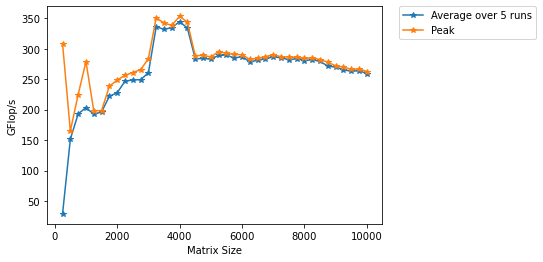

In [1]:
import timeit
import matplotlib.pyplot as plt
from IPython.display import clear_output
import numpy
%matplotlib inline

def bench_mmm(startn,maxn,step,loops):
    count=0
    
    #Preallocate results lists
    avg_gflops = int((1+(maxn-startn)/step))*[0] 
    peak_gflops = int((1+(maxn-startn)/step))*[0]
    raw_times = [int(loops)*[0] for i in range(int(1+(maxn-startn)/step))]
    all_gflops = [int(loops)*[0] for i in  range(int(1+(maxn-startn)/step))]
    mat_size=int((1+(maxn-startn)/step))*[0] 

    for n in range(startn,maxn+step,step):
        clear_output(wait=True)
        print("Running for Matrix size {0}x{0}".format(n))
        setup_string = "from pylab import rand,dot;n=%d;a=rand(n,n);b=rand(n,n)" % n
        time_list = timeit.repeat("a.dot(b)", setup=setup_string, repeat=loops,number=1)
        raw_times[count] = time_list
        total_time = sum(time_list)
        avg_time = total_time / loops
        peak_time = min(time_list)
        num_ops = 2*n**3-n**2
        avg_gflops[count] = (num_ops/avg_time)/10**9
        peak_gflops[count] = (num_ops/peak_time)/10**9
        all_gflops[count] = [(num_ops/time)/10**9 for time in raw_times[count]]        
        mat_size[count] = n
        count=count+1
    
    plt.plot(mat_size,avg_gflops,'*-',label="Average over %d runs" %loops)
    plt.plot(mat_size,peak_gflops,'*-',label="Peak")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.xlabel('Matrix Size');
    plt.ylabel('GFlop/s');
    plt.show()
    
    return(max(peak_gflops),raw_times,all_gflops)

peak_flops = bench_mmm(250,10000,250,5)

In [2]:
#Maximum flops found
result1=peak_flops[0]
result1

353.248164124909

Running for Matrix size 10000x10000


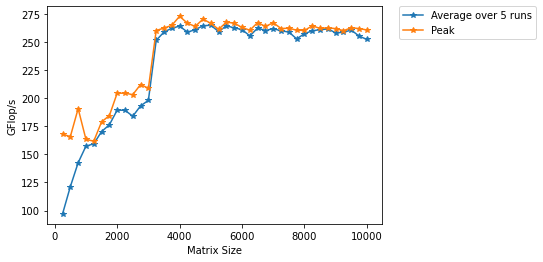

In [3]:
#Run it again
peak_flops = bench_mmm(250,10000,250,5)

In [4]:
result2=peak_flops[0]
result2

273.1209225418284

In [5]:
#Check to see if we are using MKL
import numpy
numpy.show_config()

blas_mkl_info:
    libraries = ['mkl_lapack95_lp64', 'mkl_blas95_lp64', 'mkl_rt']
    library_dirs = ['C:/Program Files (x86)/Intel/oneAPI/mkl/latest/lib/intel64']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = ['C:/Program Files (x86)/Intel/oneAPI/mkl/latest/include']
blas_opt_info:
    libraries = ['mkl_lapack95_lp64', 'mkl_blas95_lp64', 'mkl_rt']
    library_dirs = ['C:/Program Files (x86)/Intel/oneAPI/mkl/latest/lib/intel64']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = ['C:/Program Files (x86)/Intel/oneAPI/mkl/latest/include']
lapack_mkl_info:
    libraries = ['mkl_lapack95_lp64', 'mkl_blas95_lp64', 'mkl_rt']
    library_dirs = ['C:/Program Files (x86)/Intel/oneAPI/mkl/latest/lib/intel64']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = ['C:/Program Files (x86)/Intel/oneAPI/mkl/latest/include']
lapack_opt_info:
    libraries = ['mkl_lapack95_lp64', 'mkl_blas95_lp64', 

In [6]:
numpy.__version__

'1.21.5'

In [8]:
#CPU and host info.
import multiprocessing
import platform
from datetime import date
import os
from cpuinfo import get_cpu_info # Install this with pip install py-cpuinfo
info = get_cpu_info()
print("Date:{0}".format(date.today()))
print('CPUS available (May be referring to Hyperthreads) = {0}'.format(multiprocessing.cpu_count()))
print('Platform: {0}'.format(platform.platform()))
print("OMP_NUM_THREADS = {0}".format(os.getenv('OMP_NUM_THREADS')))
print('Measured peak speed = {0} Gigaflops'.format(max(result1,result2)))
print('CPU name: {0}'.format(info['brand_raw']))
print('CPU Arch: {0}'.format(info['arch']))

Date:2023-05-27
CPUS available (May be referring to Hyperthreads) = 16
Platform: Windows-10-10.0.22621-SP0
OMP_NUM_THREADS = None
Measured peak speed = 353.248164124909 Gigaflops
CPU name: 11th Gen Intel(R) Core(TM) i7-11700 @ 2.50GHz
CPU Arch: X86_64
